In [2]:
from sklearn.datasets import make_blobs
import numpy as np
import pylab as pl
%matplotlib inline

In [3]:
pl.style.use('seaborn-darkgrid')
pl.rcParams['figure.dpi'] = 300
pl.rcParams['figure.figsize'] = (3, 2)
pl.rcParams['savefig.dpi'] = 300
pl.rcParams['axes.titlesize'] = 7
pl.rcParams['axes.labelsize'] = 7
pl.rcParams['xtick.labelsize'] = 5
pl.rcParams['ytick.labelsize'] = 5
pl.rcParams['font.size'] = 7
pl.rcParams['legend.fontsize'] = 5


In [4]:
n_neurons = 50
n_trials_per_condition = 100
sigma = 0.1
n_cond = 4
x, y = make_blobs(n_samples=n_cond*n_trials_per_condition, n_features=n_neurons, centers=n_cond,
                  cluster_std=sigma, random_state=0, shuffle=False, center_box=(-1, 1))
# y[:int(len(y)/2)] = 0
# y[int(len(y)/2):] = 1

# Conditions generated in random positions, maximal dimensionality

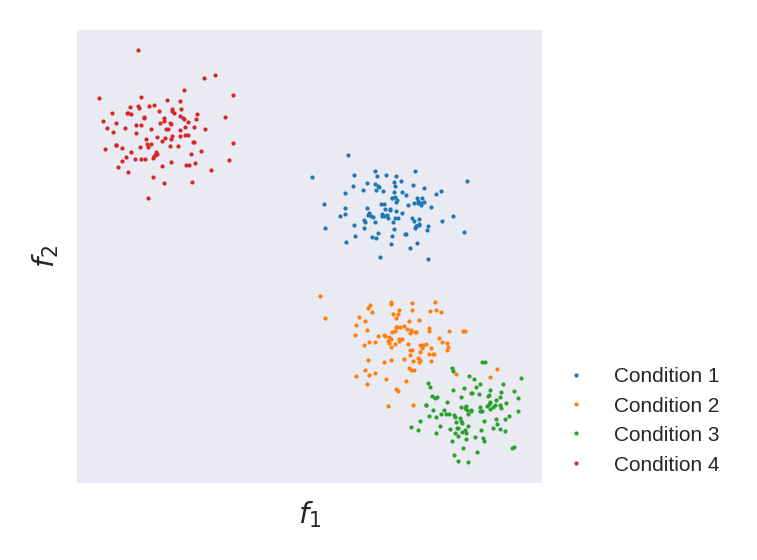

In [5]:
def plot_data(x, y, legend=True, ax=None):
    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(2, 2))
    [ax.plot(x[y==i][:, 0], x[y==i][:, 1], 'o', ms=1, mew=0) for i in np.unique(y)]
    ax.set_xlabel(r'$f_1$')
    ax.set_ylabel(r'$f_2$')
    for _, s in ax.spines.items():
        s.set_visible(False)
    ax.set_xticks(())
    ax.set_yticks(())

    if legend:
        ax.legend(['Condition %d'%(i+1) for i in np.unique(y)], loc=(1.01, 0))

ax = plot_data(x, y)

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, train_test_split

In [7]:
def make_data_high_dim(n_cond, sigma=0.1, n_neurons=100, n_trials_per_condition=50, random_state=None):
    x, y = make_blobs(n_samples=n_cond*n_trials_per_condition, n_features=n_neurons, random_state=random_state,
                      centers=n_cond, cluster_std=sigma, shuffle=False, center_box=(-1, 1))    
    return x, y

In [12]:
def assign_random_coloring(y):
    '''
    Assigns half the conditions randomly to one class and half to another class.
    '''
    if len(np.unique(y))%2 != 0:
        raise Exception("Number of conditions is odd. Please use an even number of conditions.")
    y_new = y.copy()
    which_A = np.random.permutation(np.unique(y))
    which_A = which_A[int(len(which_A)/2):]
    y_new[[yy in which_A for yy in y]] = 0
    y_new[[yy not in which_A for yy in y]] = 1
    return y_new

In [13]:
%%time

def do_simulation(make_data_function, n_conditions=24, n_neurons_max=100, n_loops=10, n_neurons_step=10):
    model = SVC(kernel='linear')
    scores = []

    n_neurons = range(1, n_neurons_max, n_neurons_step)

    for n in n_neurons:
        for i in range(n_loops):
            x, y = make_data_function(n_conditions, sigma, n_neurons=n)
            y_new = assign_random_coloring(y)
            score = cross_val_score(model, x[:, :n], y_new, cv=10)
            scores.append(1 if score.mean()>=0.8 else 0)
            print(".", end='')
        print("|", end='')

    return n_neurons, np.r_[scores].reshape(len(n_neurons), -1)
    
n_neurons, scores = do_simulation(make_data_high_dim)

..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|CPU times: user 9.95 s, sys: 266 ms, total: 10.2 s
Wall time: 10.3 s


In [14]:
from scipy import stats as sstats

In [15]:
def plot_scores(ax, x_axis, scores, color):
    m = np.mean(scores, 1)
    s = sstats.sem(scores, 1)
    ax.plot(x_axis, m, '-', color=color, lw=0.5)
    ax.fill_between(x_axis, m-s, m+s, lw=0, color=color, alpha=0.3)

Text(0,0.5,'Proportion of solved\nclassifications')

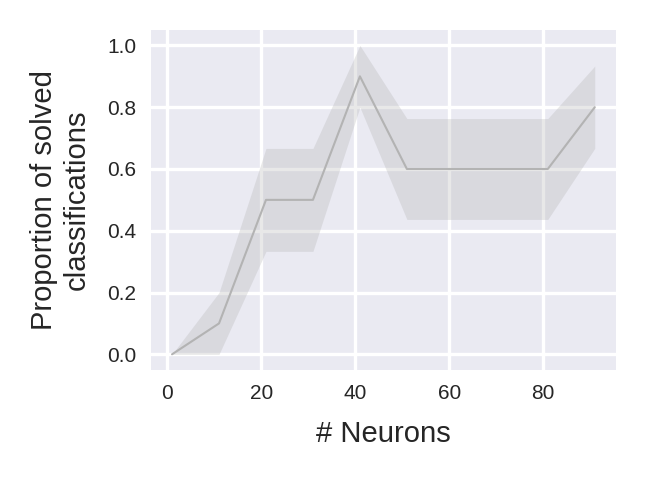

In [16]:
fig, ax = pl.subplots(1, 1, figsize=(2, 1.5))

plot_scores(ax, n_neurons, scores, '0.7')

ax.set_xlabel('# Neurons')
ax.set_ylabel('Proportion of solved\nclassifications')

# Conditions generated on a low-dimensional manifold

Similar to slide 62.

In [17]:
def make_data_low_dim(n_cond, sigma=0.1, n_neurons=50, n_dims=10, n_trials_per_condition=50, random_state=0):
    if n_dims>n_neurons:
        raise Exception("Number of dimensions can't be larger than number of neurons: %d, %d" % 
                        (n_dims, n_neurons))
    x, y = make_blobs(n_samples=n_cond*n_trials_per_condition, n_features=n_dims, random_state=random_state,
                      centers=n_cond, cluster_std=sigma, shuffle=False, center_box=(-1, 1))
    patterns = np.column_stack((x, np.zeros((x.shape[0], n_neurons-x.shape[1]))))
    
    # rotation
    rot = np.random.randn(patterns.shape[1], n_neurons)
    for i in range(rot.shape[1]):
        rot[:, i] = rot[:, i]/np.sqrt(np.dot(rot[:, i], rot[:, i]))

    x = patterns.dot(rot)#/np.sqrt(np.dot(rot, rot))
    
    return x, y

In [18]:
x, y = make_data_low_dim(4, n_dims=2, n_neurons=10, random_state=11)

In [19]:
x.shape

(200, 10)

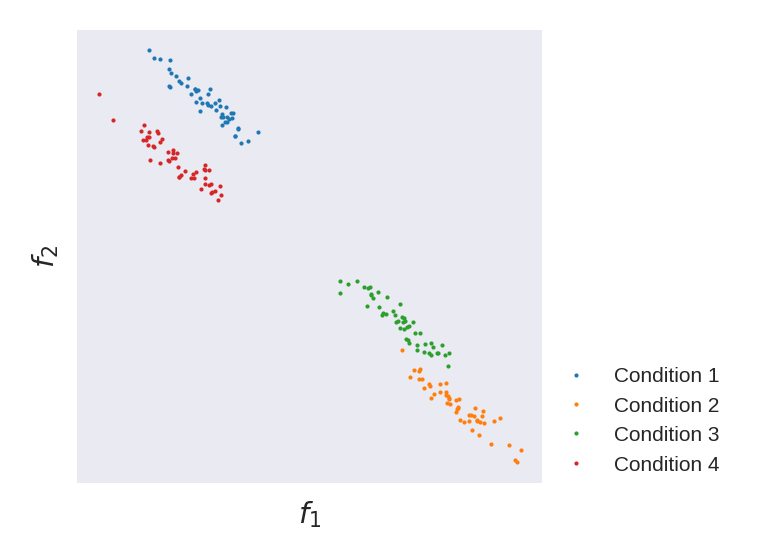

In [20]:
plot_data(x, y)

In [21]:
y_new = assign_random_coloring(y)

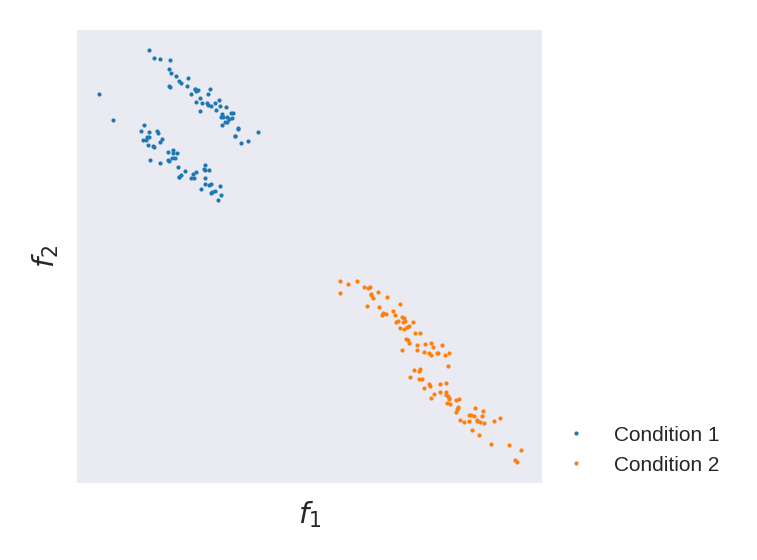

In [22]:
plot_data(x, y_new)